### Install and Import Stuff 

In [1]:
# Import libraries for suppressing warnings
import warnings
import logging
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR)
import numpy as np
warnings.warn("This is a suppressed warning!")
try:
    x = np.divide(1, 0)
except ZeroDivisionError as e:
    logging.error("Error encountered: %s", e)
# Because Warning Logs were annoying.     

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Because 'huggingface/tokenizers' told to. 
    
# @title Install and Import Stuff 
!pip install sentence-transformers==3.1.1 --quiet
!pip install scikit-learn==1.2.2 --quiet
!pip install seaborn==0.12.2 --quiet
!pip install tensorflow==2.16.1 --quiet

import pandas as pd
pd.set_option('display.max_columns', None)
import re
import string
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import joblib

### Import Dataset

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
#df = df.sample(frac=0.05, random_state=10) # Just testing with a small sample to check for errors in kaggle runtime.

# outside kaggle, use this after importing kaggle library
# !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
# !unzip imdb-dataset-of-50k-movie-reviews.zip
# df = pd.read_csv('IMDB Dataset.csv')

### Exploring the Dataset

In [3]:
# @title  Exploring the Dataset
print("* "*15)
print(f"Shape of the dataset: {df.shape}")
print("* "*15)
print(f"Columns in the dataset: {df.columns}")
print("* "*15)
print(f"Data types: {df.dtypes}")
print("* "*15)
print(f"Samples: {df.describe}")
print("* "*15)
print("Missing values in each column:")
print("* "*15)
print(df.isnull().sum())
print("* "*15)
print("Unique values in sentiment column:")
print(df['sentiment'].value_counts())


* * * * * * * * * * * * * * * 
Shape of the dataset: (50000, 2)
* * * * * * * * * * * * * * * 
Columns in the dataset: Index(['review', 'sentiment'], dtype='object')
* * * * * * * * * * * * * * * 
Data types: review       object
sentiment    object
dtype: object
* * * * * * * * * * * * * * * 
Samples: <bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  ne

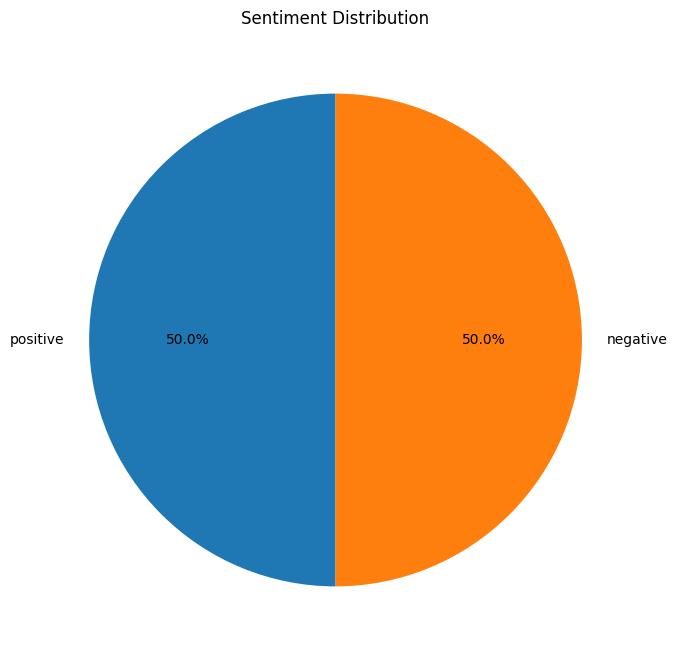

In [4]:
# @title Sentiment Distribution

sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Sentiment Distribution')

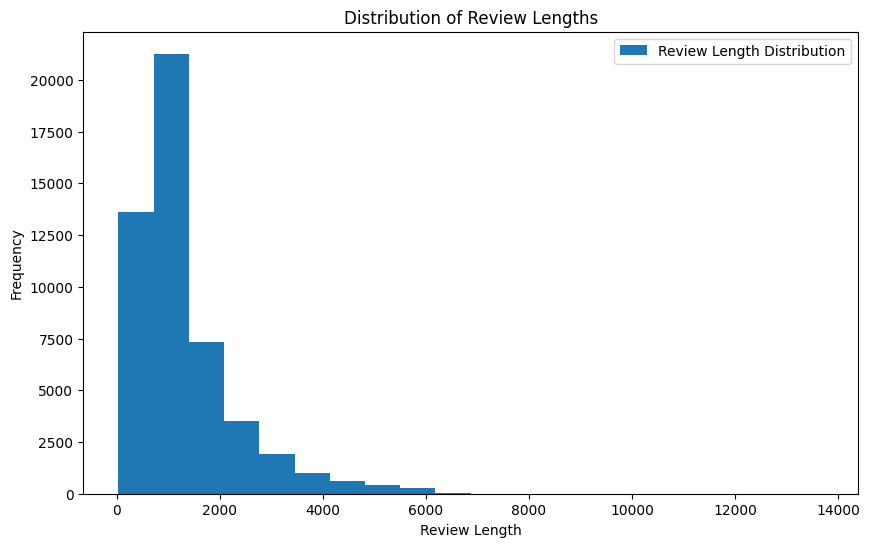

In [5]:
# @title Analysing Review Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['review'].str.len(), bins=20)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.legend(['Review Length Distribution'])
plt.show()


In [6]:
# @title Let's Clean the Data
# Drop duplicate entries
df = df.drop_duplicates()

# Encoding Sentiments to Numerical Values with .loc to avoid warnings
df.loc[:, 'sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0, 1:1, 0:0})

# Define a function that cleans the text in a single step
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits (optional)
    text = re.sub(r'\d+', '', text)
    return text

# Apply the cleaning function to the reviews
df.loc[:, 'review'] = df['review'].apply(clean_text)
# Resetting Index to reflect Dropped Duplicates. else index would stay same from before causing KeyError when a dropped column is refered.
df = df.reset_index(drop=True)

In [7]:
# @title Splitting Data

# Set a random seed for reproducibility
random_seed = 100

# Split the data into training (80%) and remaining (20%)
train_df, remaining_df = train_test_split(df, train_size=0.7, random_state=random_seed)

# Split the remaining data into validation (50%) and test (50%)
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, random_state=random_seed)

# Print the shapes of datasets
print(f"Training dataset shape: {train_df.shape}")
print(f"Validation dataset shape: {valid_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")

Training dataset shape: (34707, 2)
Validation dataset shape: (7437, 2)
Testing dataset shape: (7438, 2)


In [8]:
# @title Text Preparation for Embeddings

print("Training Data Samples:")
print(train_df['review'].sample(1).values)
print("\nValidation Data Samples:")
print(valid_df['review'].sample(1).values)
print("\nTesting Data Samples:")
print(test_df['review'].sample(1).values)

Training Data Samples:
['the only reason i give this movie an  out of  is because there are few movies in my opinion that are perfect this little b picture is a taut story well told ive always been intrigued by alexander knox but have seen him very few movies here he plays wilhelm grimm a sad little man who turns into a monster he betrays everything and everybody without an ounce of remorse the performance is one of the most chilling performances ive ever seen since world war  actors who played nazis or other evil types in films have occasionally been nominated for oscars i imagine that since this was made during the war the academy felt like honoring a performance like this would have been like honoring evil but knox puts in that kind of performancea man so bitter and consumed by guilt that he thinks nothing of making others suffer i still cant get over itmarsha hunt who usually plays the filbert gibbet or social butterfly is cast against type in probably the best performance ive ever

In [9]:
# @title Embedding : (Lengthy Process: can takes 45-120 mins on CPU Runtime, 2-3 mins on GPU Runtime)
# Load a pre-trained embedding model
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode the sentiment labels
label_encoder = LabelEncoder()
train_df['encoded_sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
# fit_transform on the train_df: The label_encoder is learning the mapping of sentiments (e.g., 'positive', 'negative') to numerical values based on the training data and then transforming the training data accordingly
valid_df['encoded_sentiment'] = label_encoder.transform(valid_df['sentiment'])
test_df['encoded_sentiment'] = label_encoder.transform(test_df['sentiment'])
# transform on the valid_df & test_df: The label_encoder uses the same mapping (learned from the training data) to transform the validation data.

# Convert reviews to embeddings
print(" Bar 1/3 : Embedding Training Data...")
train_embeddings = embedding_model.encode(train_df['review'].tolist(), show_progress_bar=True)
print(" Bar 2/3 : Embedding Validation Data...")
valid_embeddings = embedding_model.encode(valid_df['review'].tolist(), show_progress_bar=True)
print(" Bar 3/3 : Embedding Testing Data...")
test_embeddings = embedding_model.encode(test_df['review'].tolist(), show_progress_bar=True)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Bar 1/3 : Embedding Training Data...


Batches:   0%|          | 0/1085 [00:00<?, ?it/s]

 Bar 2/3 : Embedding Validation Data...


Batches:   0%|          | 0/233 [00:00<?, ?it/s]

 Bar 3/3 : Embedding Testing Data...


Batches:   0%|          | 0/233 [00:00<?, ?it/s]

In [10]:
import os
from sklearn.metrics import classification_report, accuracy_score

### METHOD 1: Simple Logistic Regression Model

In [11]:
# @title METHOD 1: Simple Logistic Regression Model
import os
from sklearn.metrics import classification_report, accuracy_score

# Create a directory for the model if it doesn't exist
model_dir = "Simple_Logistic_Model_Dir"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# Train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(train_embeddings, train_df['encoded_sentiment'])

# Evaluate the model on the test set
test_predictions = logreg_model.predict(test_embeddings)
accuracy = accuracy_score(test_df['encoded_sentiment'], test_predictions)
print(f"Logistic Regression Test Accuracy: {accuracy * 100:.2f}%")

# Print a classification report for more detailed metrics
print(classification_report(test_df['encoded_sentiment'], test_predictions))

# Save the model to the created directory
joblib.dump(logreg_model, os.path.join(model_dir, "logistic_regression_model.pkl"))
# Save the label encoder to the same directory
joblib.dump(label_encoder, os.path.join(model_dir, "label_encoder.pkl"))
print(f"Model and Label Encoder saved to {model_dir}")


Logistic Regression Test Accuracy: 80.18%
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      3704
           1       0.81      0.80      0.80      3734

    accuracy                           0.80      7438
   macro avg       0.80      0.80      0.80      7438
weighted avg       0.80      0.80      0.80      7438

Model and Label Encoder saved to Simple_Logistic_Model_Dir


### METHOD 2: Logistic Regression with GridSearchCV

In [12]:
# @title METHOD 2: Logistic Regression with GridSearchCV
import os
from sklearn.metrics import classification_report, accuracy_score

# Create a directory for the model if it doesn't exist
model_dir = "GridSearchCV_logistic_model_Dir"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'], 
    'penalty': ['l1', 'l2'] 
}

logreg_model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_embeddings, train_df['encoded_sentiment'])

# Get the best model
best_logreg_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_predictions = best_logreg_model.predict(test_embeddings)
accuracy = accuracy_score(test_df['encoded_sentiment'], test_predictions)
print(f"Best Logistic Regression Test Accuracy: {accuracy * 100:.2f}%")

# Print a classification report for more detailed metrics
print(classification_report(test_df['encoded_sentiment'], test_predictions))

# Save the best model to the created directory
joblib.dump(best_logreg_model, os.path.join(model_dir, "best_logistic_regression_model.pkl"))
# Save the label encoder to the same directory
joblib.dump(label_encoder, os.path.join(model_dir, "label_encoder.pkl"))
print(f"Best Model and Label Encoder saved to {model_dir}")


Best Logistic Regression Test Accuracy: 80.12%
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      3704
           1       0.81      0.80      0.80      3734

    accuracy                           0.80      7438
   macro avg       0.80      0.80      0.80      7438
weighted avg       0.80      0.80      0.80      7438

Best Model and Label Encoder saved to GridSearchCV_logistic_model_Dir


In [13]:
from sklearn.metrics import classification_report, accuracy_score

def Simple_RandomForest_model():
    # Create a directory for the model if it doesn't exist
    model_dir = "Simple_RandomForest_model_Dir"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Train the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=500, 
        max_depth=10,  
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=100
    )
    rf_model.fit(train_embeddings, train_df['encoded_sentiment'])
    
    # Evaluate the model on the test set
    test_predictions = rf_model.predict(test_embeddings)
    accuracy = accuracy_score(test_df['encoded_sentiment'], test_predictions)
    print(f"Random Forest Test Accuracy: {accuracy * 100:.2f}%")
    
    # Print a classification report for more detailed metrics
    print(classification_report(test_df['encoded_sentiment'], test_predictions))
    
    # Save the model to the created directory
    joblib.dump(rf_model, os.path.join(model_dir, "random_forest_model.pkl"))
    # Save the label encoder to the same directory
    joblib.dump(label_encoder, os.path.join(model_dir, "label_encoder.pkl"))
    print(f"Model and Label Encoder saved to {model_dir}")
    
    return rf_model

simple_randomforest_model = Simple_RandomForest_model()


Random Forest Test Accuracy: 76.31%
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      3704
           1       0.75      0.78      0.77      3734

    accuracy                           0.76      7438
   macro avg       0.76      0.76      0.76      7438
weighted avg       0.76      0.76      0.76      7438

Model and Label Encoder saved to Simple_RandomForest_model_Dir


In [14]:
from sklearn.metrics import accuracy_score, classification_report

def LSTM_model():
    model_dir = "LSTM_model_Dir"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(train_df['review'])
    
    # Convert text to sequences of integers
    train_sequences = tokenizer.texts_to_sequences(train_df['review'])
    valid_sequences = tokenizer.texts_to_sequences(valid_df['review'])
    test_sequences = tokenizer.texts_to_sequences(test_df['review'])
    
    # Pad sequences to have the same length
    max_sequence_length = 100
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
    valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_sequence_length)
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)
    
    # Define the LSTM model
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
    lstm_model.add(LSTM(128, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(128))
    lstm_model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    lstm_model.fit(
        train_padded_sequences, train_df['encoded_sentiment'],
        epochs=5, 
        batch_size=64,
        validation_data=(valid_padded_sequences, valid_df['encoded_sentiment']),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )
    
    # Evaluate the model on the test set
    loss, accuracy = lstm_model.evaluate(test_padded_sequences, test_df['encoded_sentiment'], verbose=0)
    print(f"LSTM Test Accuracy: {accuracy * 100:.2f}%")
    
    # Generate predictions for classification report
    test_predictions = (lstm_model.predict(test_padded_sequences) > 0.5).astype("int32")
    
    # Print a classification report for more detailed metrics
    print(classification_report(test_df['encoded_sentiment'], test_predictions))
    
    # Save the model and tokenizer to the model directory
    lstm_model.save(os.path.join(model_dir, 'lstm_model.h5'))
    with open(os.path.join(model_dir, 'tokenizer.pickle'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    joblib.dump(label_encoder, os.path.join(model_dir, "label_encoder.pkl"))
    
    print(f"Model and Tokenizer saved to {model_dir}")
    return lstm_model, tokenizer

# Train and save the model
lstm_model, tokenizer = LSTM_model()


Epoch 1/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7520 - loss: 0.4823 - val_accuracy: 0.8567 - val_loss: 0.3299
Epoch 2/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8754 - loss: 0.2975 - val_accuracy: 0.8594 - val_loss: 0.3320
Epoch 3/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9022 - loss: 0.2445 - val_accuracy: 0.8552 - val_loss: 0.3385
Epoch 4/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9213 - loss: 0.2036 - val_accuracy: 0.8478 - val_loss: 0.3819
LSTM Test Accuracy: 84.55%
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3704
           1       0.83      0.87      0.85      3734

    accuracy                           0.85      7438
   macro avg       0.85      0.85      0.85      7438
weighted avg       0.85      0.85      0.85      7438

Model and Tokenizer saved to LSTM_model_Dir


### Predict using Models

In [15]:
print("*"*20)
print("*"*20)
print("Loading all models back from savefiles")

# Load the simple logistic regression model
simple_logistic_model_dir = "Simple_Logistic_Model_Dir"
simple_logistic_model = joblib.load(os.path.join(simple_logistic_model_dir, "logistic_regression_model.pkl"))
print("Simple Logistic Regression Model loaded successfully.")

# Load the GridSearchCV logistic regression model
gridsearchcv_logistic_model_dir = "GridSearchCV_logistic_model_Dir"
gridsearchcv_logistic_model = joblib.load(os.path.join(gridsearchcv_logistic_model_dir, "best_logistic_regression_model.pkl"))
print("GridSearchCV Logistic Regression Model loaded successfully.")

# Load the simple Random Forest model
simple_randomforest_model_dir = "Simple_RandomForest_model_Dir"
simple_randomforest_model = joblib.load(os.path.join(simple_randomforest_model_dir, "random_forest_model.pkl"))
print("Simple Random Forest Model loaded successfully.")

# Load the LSTM model
lstm_model_dir = "LSTM_model_Dir"
lstm_model_loaded = tf.keras.models.load_model(os.path.join(lstm_model_dir, "lstm_model.h5"))
print("LSTM Model loaded successfully.")

# Load the tokenizer
with open(os.path.join(lstm_model_dir, "tokenizer.pickle"), 'rb') as handle:
    tokenizer = pickle.load(handle)
    print("Tokenizer loaded successfully.")

# Load the label encoder
label_encoder = joblib.load(os.path.join(lstm_model_dir, "label_encoder.pkl"))
print("Label Encoder loaded successfully.")
print("Everything loaded successfully from ModelSaves.")
print("*"*20)
print("*"*20)


********************
********************
Loading all models back from savefiles
Simple Logistic Regression Model loaded successfully.
GridSearchCV Logistic Regression Model loaded successfully.
Simple Random Forest Model loaded successfully.
LSTM Model loaded successfully.
Tokenizer loaded successfully.
Label Encoder loaded successfully.
Everything loaded successfully from ModelSaves.
********************
********************


In [16]:
def predict_with_simple_logistic_regression(embedding):
    """Predicts sentiment using the simple logistic regression model."""
    prediction = simple_logistic_model.predict(embedding)[0]
    return prediction

def predict_with_gridsearchcv_logistic_regression(embedding):
    """Predicts sentiment using the GridSearchCV logistic regression model."""
    prediction = gridsearchcv_logistic_model.predict(embedding)[0]
    return prediction

def predict_with_random_forest(embedding):
    """Predicts sentiment using the Random Forest model."""
    prediction = simple_randomforest_model.predict(embedding)[0]
    return prediction

def predict_with_lstm(text):
  """Predicts sentiment using the LSTM model."""
  sequence = tokenizer.texts_to_sequences([text])
  padded_sequence = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')
  prediction = lstm_model_loaded.predict(padded_sequence)[0][0]
  return 1 if prediction > 0.5 else 0  # Threshold for binary classification


In [17]:
reviews = [
    {"reviewText": "James Cameron's 'Terminator' is a masterpiece of sci-fi action. The relentless pace, iconic performances, and groundbreaking special effects make it a must-watch.", "reviewType": "positive"},
    {"reviewText": "The 'Terminator' is a thrilling and suspenseful ride from start to finish. The concept of a cyborg assassin from the future is both terrifying and fascinating.", "reviewType": "positive"},
    {"reviewText": "Arnold Schwarzenegger's portrayal of the Terminator is legendary. He delivers a chilling performance that perfectly embodies the relentless machine.", "reviewType": "positive"},
    {"reviewText": "The 'Terminator' is a timeless classic that continues to entertain and inspire awe even today. Its influence on the sci-fi genre is undeniable.", "reviewType": "positive"},
    {"reviewText": "The film's action sequences are breathtaking. The chase scenes and the final showdown are particularly memorable.", "reviewType": "positive"},
    {"reviewText": "The 'Terminator' suffers from a predictable plot and underdeveloped characters. The focus on action overshadows any attempt at meaningful storytelling.", "reviewType": "negative"},
    {"reviewText": "The special effects, while groundbreaking for their time, haven't aged well. The CGI looks dated and detracts from the overall experience.", "reviewType": "negative"},
    {"reviewText": "The film's pacing is uneven. Some scenes drag on while others feel rushed, resulting in a disjointed viewing experience.", "reviewType": "negative"},
    {"reviewText": "The 'Terminator' relies too heavily on violence and gore. The lack of emotional depth makes it difficult to connect with the characters.", "reviewType": "negative"},
    {"reviewText": "The film's ending is abrupt and unsatisfying. It leaves many questions unanswered and fails to provide a sense of closure.", "reviewType": "negative"}
]

In [18]:
from tabulate import tabulate

table_data = []
for review in reviews:
    review_text = review["reviewText"]
    expected_type = review["reviewType"]

    # Embed the text only once
    
    embedding = embedding_model.encode([review_text])
    model1_response = predict_with_simple_logistic_regression(embedding)
    model2_response = predict_with_gridsearchcv_logistic_regression(embedding)
    model3_response = predict_with_random_forest(embedding)
    model4_response = predict_with_lstm(review_text)  # LSTM uses a different input format

    table_data.append([
        review_text[:50],
        model1_response,
        model2_response,
        model3_response,
        model4_response
    ])


table_headers = ["Review", "Expected", "SLR", "GLR", "RF", "LSTM"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
+----------------------------------------------------+------------+-------+-------+------+
| Review                                             |   Expected |   SLR |   GLR |   RF |
+====================================================+============+=======+=======+======+
| James Cameron's 'Terminator' is a masterpiece of s |          1 |     1 |     1 |    1 |
+----------------------------------------------------+------------+-------+-------+------+
| The 'Terminator' is a thrilling and suspenseful ri |          1 |     1 |     1 |    1 |
+----------------------------------------------------+------------+-------+-------+------+
| Arnold Schwarzenegger's portrayal of the Terminato |          1 |     1 |     1 |    1 |
+----------------------------------------------------+------------+-------+-------+------+
| The 'Terminator' is a timeless classic that contin |          1 |     1 |     1 |    1 |
+---------------------------------------------------